# Imputing age and gender

#### (a)
  *  Two regression models using the data in *SurveyIncome* should be first constructed. Using *tot_inc* and *wgt* as regressors, the first and the second model will predict the *age* and *gender*, respectively. Especially, the logistic regression model should be employed for the second model because the *gender* variable is binary in this context. 
  
  
  * Next, *lab_inc* and *cap_inc* in *BestIncome* dataset will be summed up to compute the total income of each individual. Then, the total income and weight variable will be entered into the two estimated models in the previous step to generate the imputed values of *age* and *gender*. Note that the output of the logistic regression falls between 0 and 1 so .5 will be the cut-off point (if greater than .5, then female), though other values can be used if any plausible reason exists. 

#### (b)

  * The following R code is used to impute the age and gender variable into the BestIncome.txt data.
  

In [1]:
library(tidyverse)

#read data
bestincome <- read.csv("BestIncome.txt", sep = ",", header = F)
surveyincome <- read.csv("SurvIncome.txt", sep = ",", header = F)

#labeling columns
names(bestincome) <- c("lab_inc", "cap_inc", "hgt", "wgt")
names(surveyincome) <- c("tot_inc", "wgt", "age", "gender")

#linear model for age
age_mod <- lm(data = surveyincome, 
              age ~ tot_inc + wgt)

#linear model for gender
gender_mod <- glm(data = surveyincome, 
                  gender ~ tot_inc + wgt, family = "binomial")

#creating tot_inc in bestincome
bestincome$tot_inc <- bestincome$lab_inc + bestincome$cap_inc

#predicting age and gender using the estimated model
bestincome$age <- predict(age_mod, newdata = bestincome)
bestincome$pred_gender <- predict(gender_mod, 
                                  newdata = bestincome, 
                                  type = "response")
bestincome$gender <- ifelse(bestincome$pred_gender > 0.5, 1, 0)

head(bestincome)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.0.0     √ purrr   0.2.5
√ tibble  1.4.2     √ dplyr   0.7.6
√ tidyr   0.8.1     √ stringr 1.3.1
√ readr   1.1.1     √ forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


lab_inc,cap_inc,hgt,wgt,tot_inc,age,pred_gender,gender
52655.61,9279.510,64.56814,152.9206,61935.12,44.74261,0.259426864,0
70586.98,9451.017,65.72765,159.5344,80038.00,45.15439,0.001096766,0
53738.01,8078.132,66.26880,152.5024,61816.14,44.74243,0.300714656,0
55128.18,12692.670,62.91056,149.2182,67820.85,44.91584,0.422430661,0
44482.79,9812.976,68.67830,152.7264,54295.77,44.55139,0.556197197,1
55394.63,10769.461,67.37055,151.6027,66164.09,44.85805,0.246243467,0


#### (c)

 * The following R code is used to calculate the values.

In [2]:
bestincome_6vars <- bestincome %>%
  select(-pred_gender, -tot_inc)

desc_stats <- data.frame(
  lapply(bestincome_6vars , function(x) rbind(mean = mean(x),
                                  sd = sd(x),
                                  minimum = min(x),
                                  maximum = max(x),
                                  obs = length(x)))
)

round(desc_stats,2)

,lab_inc,cap_inc,hgt,wgt,age,gender
mean,57052.93,9985.80,65.01,150.01,44.89,4.5e-01
sd,8036.54,2010.12,2.00,9.97,0.22,5.0e-01
minimum,22917.61,1495.19,58.18,114.51,43.98,0.0e+00
maximum,90059.90,19882.32,72.80,185.41,45.70,1.0e+00
obs,10000.00,10000.00,10000.00,10000.00,10000.00,1.0e+04


* The following R code is used to generate the correlation matrix for six variables.

In [3]:
#corr matrix
res <- cor(bestincome[c("lab_inc", "cap_inc", 
                        "hgt", "wgt", "age", "gender")])
round(res, 2)

,lab_inc,cap_inc,hgt,wgt,age,gender
lab_inc,1.00,0.01,0.00,0.00,0.92,-0.22
cap_inc,0.01,1.00,0.02,0.01,0.23,-0.06
hgt,0.00,0.02,1.00,0.17,-0.05,-0.13
wgt,0.00,0.01,0.17,1.00,-0.30,-0.76
age,0.92,0.23,-0.05,-0.30,1.00,0.02
gender,-0.22,-0.06,-0.13,-0.76,0.02,1.00


# Stationarity and data drift

#### (a)

* The R codes below are used to estimate the model.

In [4]:
library(broom)
library(ggplot2)

Income_Intel <- read.csv("incomeIntel.txt", sep = ",", header = F)
names(Income_Intel) <- c("grad_year", "gre_qnt", "salary_p4")

model_a <- lm(data = Income_Intel, salary_p4 ~ gre_qnt)
tidy(model_a)

term,estimate,std.error,statistic,p.value
(Intercept),59015.282543,744.575574,79.260299,0.0000000
gre_qnt,1.742264,1.154491,1.509118,0.1315851


#### (b)

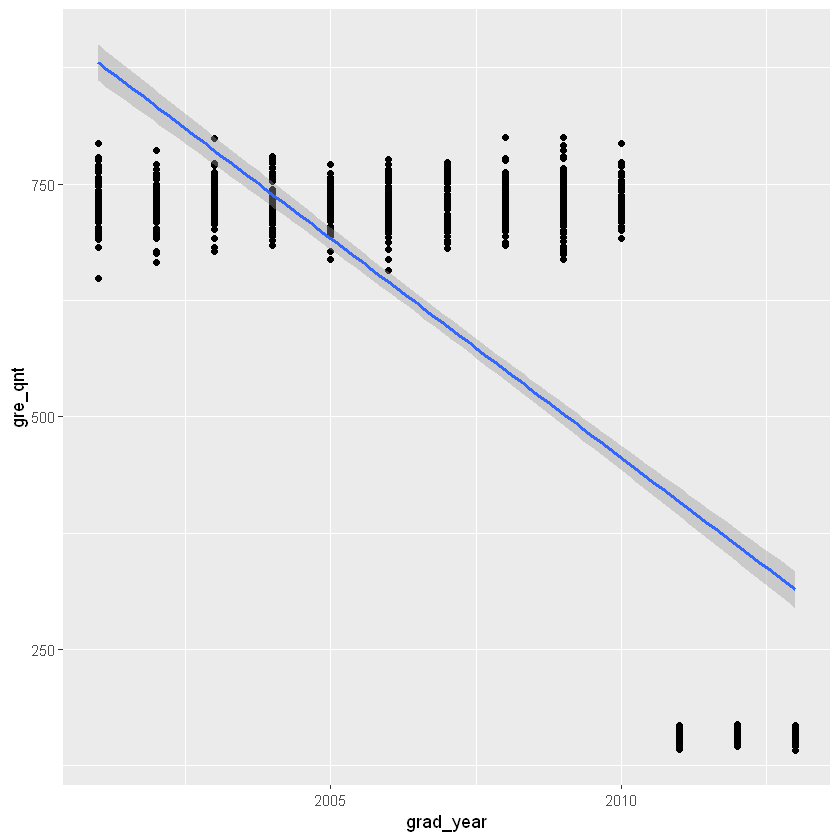

In [5]:
Income_Intel %>%
  ggplot(aes(x = grad_year, y = gre_qnt)) + 
            geom_point() + 
            geom_smooth(method = "lm")

 * I think we can use the new-old score concordance table ([link](https://www.ets.org/s/gre/pdf/concordance_information.pdf)) provided by ETS to transform the new GRE scores from 2011 to old scores (or vice versa). Here I chose to first round the scores of new GRE scores and transform them to the old scale. 

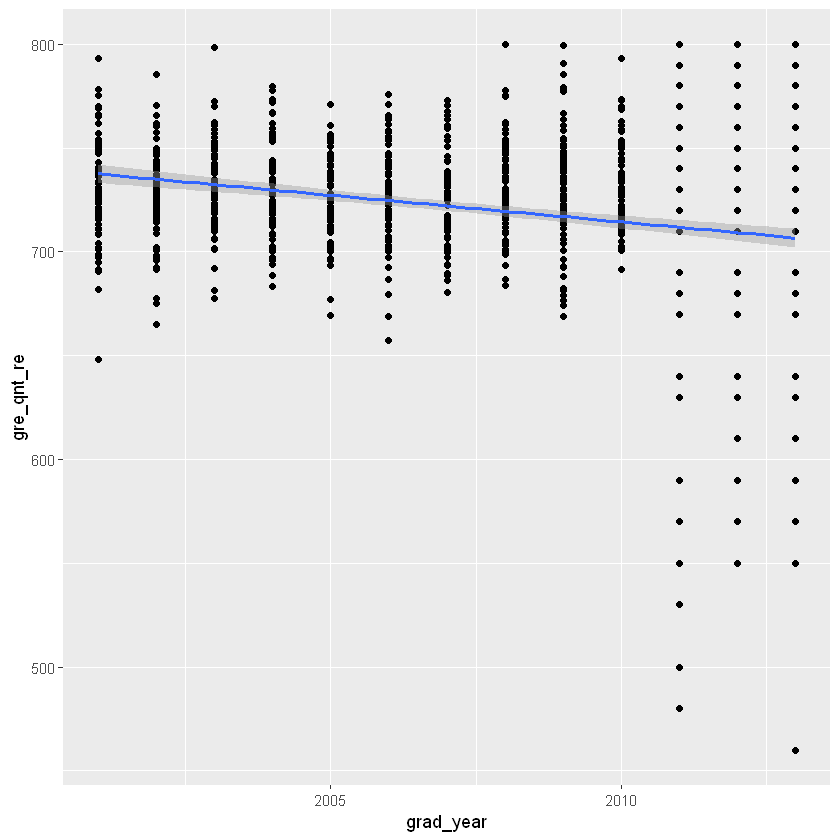

In [6]:
#score conversion from new to old using ETS's concordance Table
Income_Intel <- Income_Intel %>%
  
  mutate(t = round(gre_qnt),
         gre_qnt_re = ifelse(gre_qnt > 170, gre_qnt, 
                             ifelse(t >= 166, 800,
                             ifelse(t >= 164, 790,
                             ifelse(t == 163, 780, 
                             ifelse(t >= 161, 770,
                             ifelse(t == 160, 760,
                             ifelse(t == 159, 750,
                             ifelse(t == 158, 740,
                             ifelse(t == 157, 730,
                             ifelse(t == 156, 720,
                             ifelse(t == 155, 710,
                             ifelse(t == 154, 690,
                             ifelse(t == 153, 680,
                             ifelse(t == 152, 670,
                             ifelse(t == 151, 640,
                             ifelse(t == 150, 630,
                             ifelse(t == 149, 610,
                             ifelse(t == 148, 590,
                             ifelse(t == 147, 570,
                             ifelse(t == 146, 550,
                             ifelse(t == 145, 530,
                             ifelse(t == 144, 500,
                             ifelse(t == 143, 480,
                             ifelse(t == 142, 460, NA)
                                    )))))))))))))))))))))))
  )

Income_Intel %>%
  ggplot(aes(x = grad_year, y = gre_qnt_re)) + 
            geom_point() + 
            geom_smooth(method = "lm")

#### (c)

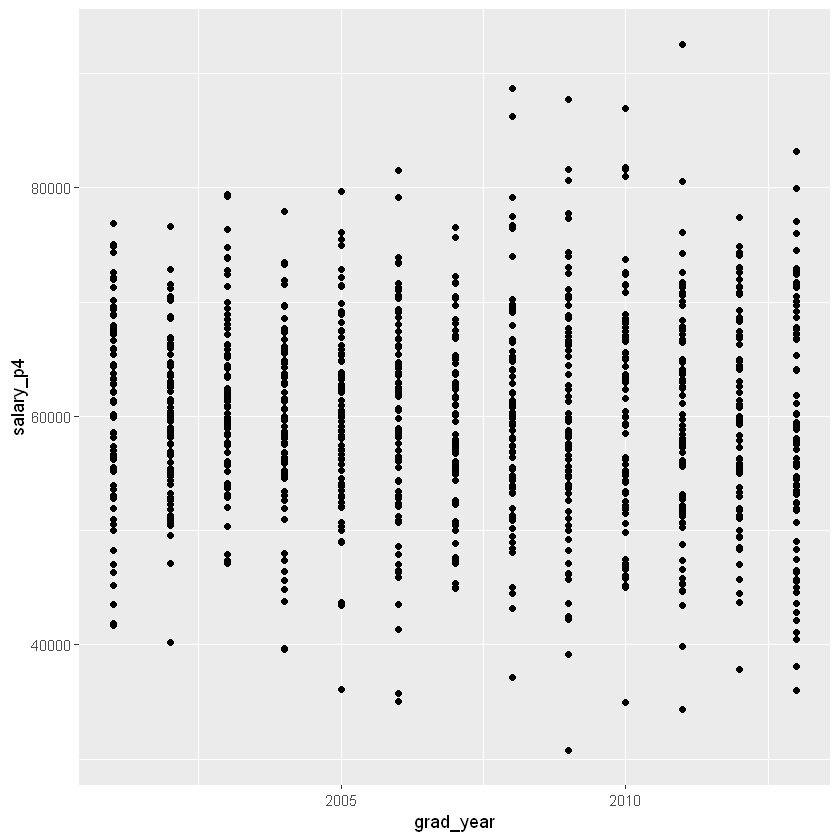

In [7]:
Income_Intel %>%
  ggplot(aes(x = grad_year, y = salary_p4)) + geom_point()

* Even though the means of income 4 years after graduation across the years seem similar, we cannot exclude the possibility that the situation of job markets in each year might have been different. So, I here propose to normalize each individual's salary; in other words, I suggest to compute the Z-scores of the individual's salary using each year's mean and standard deviation (here I assume that the income data is an inflation adjusted one.) I think transformation makes the comparison of individuals who graduated different time more reasonable.

In [8]:
Income_Intel <- Income_Intel %>%
  group_by(grad_year) %>%
  #scale function calculates Z-score using group mean snd sd
  mutate(salary_normalized = scale(salary_p4)) 
head(Income_Intel)
tail(Income_Intel)

grad_year,gre_qnt,salary_p4,t,gre_qnt_re,salary_normalized
2001,719.3358,67985.21,719,719.3358,0.86648826
2001,717.8670,53632.22,718,717.8670,-0.87369933
2001,765.4302,68951.36,765,765.4302,0.98362721
2001,737.8455,71942.00,738,737.8455,1.34621881
2001,715.7818,61322.13,716,715.7818,0.05864258
2001,736.3663,53060.30,736,736.3663,-0.94304018


grad_year,gre_qnt,salary_p4,t,gre_qnt_re,salary_normalized
2013,155.4385,83205.24,155,710,2.2539889
2013,149.8718,50745.79,150,630,-0.7260924
2013,165.4917,42096.92,165,790,-1.5201395
2013,152.7377,53168.36,153,680,-0.5036772
2013,145.8693,70449.27,146,550,1.0828717
2013,158.7957,72944.82,159,750,1.3119865


#### (d)

In [9]:
model_d <- lm(data = Income_Intel, salary_normalized ~ gre_qnt_re)
tidy(model_d)

term,estimate,std.error,statistic,p.value
(Intercept),-0.3679158419,0.5770371724,-0.6375947,0.5238838
gre_qnt_re,0.0005094658,0.0007978564,0.6385433,0.5232666


* Comparing to the model estimated in part (a), the regression coefficient of GRE quant score drastically decreased (from 1.7422 -> 0.0005). And the p-values of both intercept and gre_qnt increased (both over .50). This change was caused because the model in part (d) now reflect the change of the score scale (the system drift) and (2) of the variability of the job markets. The result shows that the quant scores of GRE are almost relevant to income 4 years after graduation, which I think is plausible because there exist tons and thousands other variables such as family background, gender, major, occupation etc., that could affect individuals' income.  

# Assessment of Kossinets and Watts (2009)

#### (a)

* What kinds of the mechanisms explain the generation of homophilic ties (the tendency of like to associate with like) observed in the interpersonal network?

#### (b)
 * The authors used three data sources to construct the data of 30,396 students, faculty, and staff in a U.S. university: (1) the logs of e-mail interactions within the university over one academic year (more precisely, 270 days), (2) a database of individual attributes, (3) records of course registration. 
 
 
 * The final data includes 30,396 individuals in the university who had been used the university email accounts for the given time period, i.e., one academic year (or two semesters). The initial number of individuals they targeted was 43,553. However, the authors first got rid of approximately 9,000 people because they had been inactive during the first and the last month of the academic year and also excluded about 4,000 people who exchanged emails with people outside the subset (university community). 
 
 
 * The network data constructed based on the email exchange among people in the university includes 7,156,162 messages with senders IDs, recipients IDs, the time stamp in minutes. This data is used to compute the network degree measures for each individual. 
 
#### (c)
 * The authors employed various strategies to impute the missing data. First, they utilized the fact that some unchanging missing values such as a date of birth could be found at the different time point beyond the one-academic year time frame. And as for confusing variable like gender, they relied on so-called heuristics, which includes using modal values, backward interpolation, and forward interpolation. 
 
 
 * In the case of demographic variables such as a year of birth and gender, I think using modal values was a valid approach. However, I think that the fact they relied on various types of interpolation to fill the missing values could be problematic because of the issue of selectivity or bias. In other words, if the underlying characteristics of people who had missing values and those who were dissimilar in the first place, it does not make sense to interpolate the missing values based on the models using the non-missing values in the records. 
 
 
#### (d)
 * As the authors point out in the discussion section, the email exchange in a professional setting (i.e., a large U.S. university) might not be representative to generalize their argument on the evolutionary process of the formation of homophilic social relation. The social relationships the authors measured using email exchange could be different from the relationships we can observe in various other formal or informal organizational settings.
 
 
 * Despite this weakness, they argued that the theoretical implications of the result should not be rejected because their question of the origin of homophily can be conceived as one of the cases of "structure versus agency" issues, which has long been debated. And the authors basically admitted the limitation of their data and called for further research, especially emphasizing the importance of the comparative analyses using different settings such as business firms, government agencies, and etc. 